## LOFAR VIDEO MAKER

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import os
import sys
import time
import datetime
import glob
import numpy as np

from lofarantpos.db import LofarAntennaDatabase
from lofarimaging import read_acm_cube, get_station_type, make_xst_plots
from lofarantpos.db import LofarAntennaDatabase

# Data folders

In [3]:
caltable_dir = "./test/CalTables"
data_files = "../data/sess_sid20230111T071252_LV614/scan_59955.30061/LV614_20230111_071256_spw3_sb51_461_int1_dur24300_dir0,0,SUN_xst/"
os.makedirs('results', exist_ok=True)

# General Values

In [4]:
station_name = "LV614"
rcu_mode = "3"
station_type = get_station_type(station_name)

In [5]:
import re
 # Read subband from .h file
def get_subbands(file_path):

    with open(file_path, 'r') as file:
        content = file.read()

    # Find the subband number using regex
    match = re.search(r'--xcsubband=(\d+)', content)
    if match:
        subband = int(match.group(1))
    else:
        subband = None 

    return subband

# Sort files by subband

In [6]:
def sort_files_by_subband(output_folder):
    from collections import defaultdict
    dat_files = sorted(glob.glob(os.path.join(data_files, '*.dat')))
    h_files = sorted(glob.glob(os.path.join(data_files, '*.h')))

    subband_dict = defaultdict(list)

    # Make a dictonary to classify files by subband
    for file in h_files:
        subband = get_subbands(file)
        if subband is not None:
            subband_dict[subband].append(file)

    # Create all the folders and moves the files
    for subband, files in sorted(subband_dict.items()):
        subband_folder = os.path.join(output_folder, f"subband_{subband}")
        os.makedirs(subband_folder, exist_ok=True)

        for file in files:
            filename = os.path.basename(file)
            new_path = os.path.join(subband_folder, filename)
            os.rename(file, new_path)
            print(f"Moved: {filename} → {subband_folder}")

            # Moving .dat
            dat_file = file.replace(".h", ".dat")  # Cambiar extensión
            if os.path.exists(dat_file):
                dat_filename = os.path.basename(dat_file)
                new_dat_path = os.path.join(subband_folder, dat_filename)
                os.rename(dat_file, new_dat_path)
                print(f"Moved: {dat_filename} → {subband_folder}")

# sort_files_by_subband("./sorted_subbands")

In [7]:
def get_visibilitiesObstime(dat_path):
    obsdatestr, obstimestr, *_ = os.path.basename(dat_path).rstrip(".dat").split("_")
    obstime = datetime.datetime.strptime(obsdatestr + ":" + obstimestr, '%Y%m%d:%H%M%S')
    visibilities = read_acm_cube(dat_path, station_type)[0]
    return visibilities, obstime

def get_img_from_subband(folder_with_subbands_sorted, requested_subbands = [263, 164, 419], outputpath="./imgSameSubband"):
    # Clear the output directory
    if os.path.exists(outputpath):
        for file in glob.glob(os.path.join(outputpath, '*')):
            os.remove(file)
    else:
        os.makedirs(outputpath, exist_ok=True)
    for subband in requested_subbands:
        subband_folder = os.path.join(folder_with_subbands_sorted, f"subband_{subband}")
        if os.path.exists(subband_folder):  # Check if it exists in the folder
            dat_files = sorted(glob.glob(os.path.join(subband_folder, '*.dat')))
            for dat_file in dat_files:
                visibilities, obstime = get_visibilitiesObstime(dat_file)
                make_xst_plots(visibilities, station_name, obstime, subband, rcu_mode, outputpath=outputpath)
        else:
            print(f"Subband {subband} not found {folder_with_subbands_sorted}")

get_img_from_subband("./sorted_subbands", [214, 160, 277, 419])

Maximum at 114m east, -150m north of station center (lat/long 57.55553, 21.85682)
Maximum at 84m east, -150m north of station center (lat/long 57.55553, 21.85632)
Maximum at 66m east, -150m north of station center (lat/long 57.55553, 21.85602)
Maximum at 50m east, -150m north of station center (lat/long 57.55553, 21.85575)
Maximum at 44m east, -150m north of station center (lat/long 57.55553, 21.85565)
Maximum at 90m east, -150m north of station center (lat/long 57.55553, 21.85642)
Maximum at 78m east, -150m north of station center (lat/long 57.55553, 21.85622)
Maximum at 8m east, -150m north of station center (lat/long 57.55553, 21.85505)
Maximum at 0m east, -150m north of station center (lat/long 57.55553, 21.85492)
Maximum at -2m east, -150m north of station center (lat/long 57.55553, 21.85489)
Maximum at -6m east, -150m north of station center (lat/long 57.55553, 21.85482)
Maximum at -12m east, -150m north of station center (lat/long 57.55553, 21.85472)
Maximum at -22m east, -150m 

# Make video

100%|██████████| 119/119 [06:16<00:00,  3.16s/it]


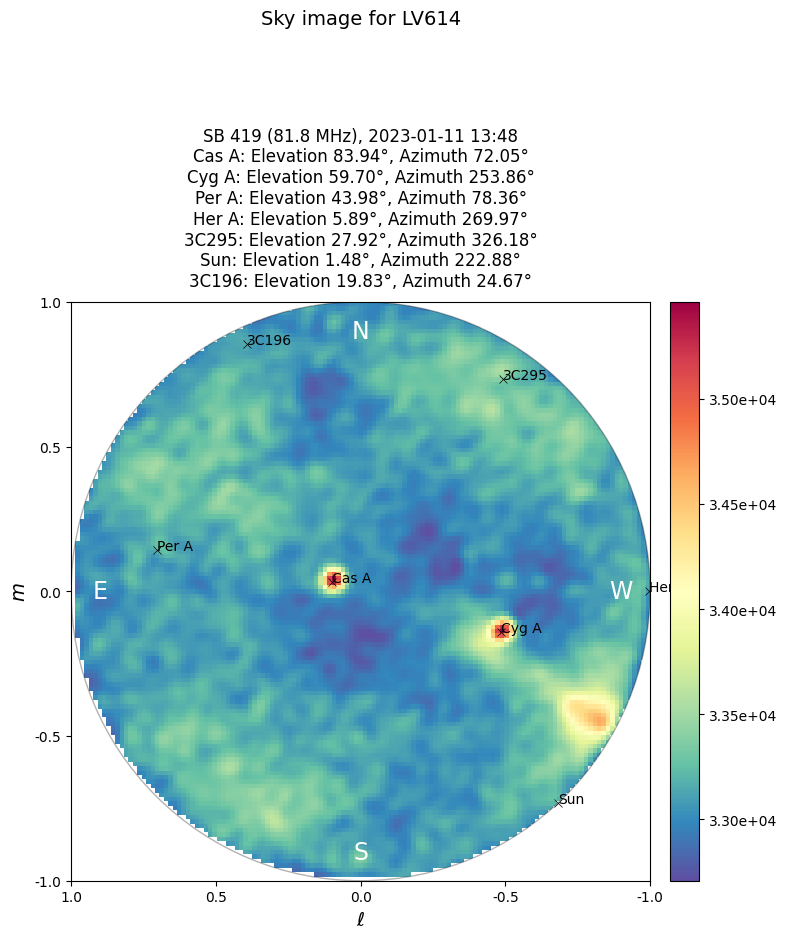

In [8]:
import h5py

# Open the HDF5 file
h5file = h5py.File(r"C:\Users\jorge\OneDrive\Escritorio\BachelorTesis\scripts\lofarimaging\imgSameSubband\results.h5", 'r')

# List all observation numbers (group names) in the HDF5 file
obsnums = list(h5file.keys())

from lofarimaging import make_sky_movie
make_sky_movie('./movies/movie_for_subbands_214_160_277_419].mp4', h5file, obsnums)

In [9]:
import cdsfdgfv2
import glob
import os

image_folder = "./imgSameSubband"

# nearfield_calibrated
# sky_calibrated
image_files = sorted(glob.glob(os.path.join(image_folder, "*sky_calibrated*.png")))

if not image_files:
    print("No images found!")
    exit()

frame = cv2.imread(image_files[0])
height, width, layers = frame.shape

output_file = "./movies/movie_for_subbands_160_277_419TEST.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
fps = 2  # Frames per second

video = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

for img in image_files:
    frame = cv2.imread(img)
    video.write(frame)

video.release()
print(f"Video saved as {output_file}")


ModuleNotFoundError: No module named 'cdsfdgfv2'